In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


# --- MRI Data (insert your full list here) ---
mri_data = [
    {'Mouse': '3X', 'Infected': False, 'Week': 7, 'Uterus_Volume': 92600, 'Cyst_Volume': 4175, 'Cysts_to_Uterus': 4.51, 'LN_Volume': 6.90},
    {'Mouse': '3R', 'Infected': False, 'Week': 7, 'Uterus_Volume': 185800, 'Cyst_Volume': 36490, 'Cysts_to_Uterus': 19.64, 'LN_Volume': 3.54},
    {'Mouse': '3L', 'Infected': False, 'Week': 7, 'Uterus_Volume': 337200, 'Cyst_Volume': 103700, 'Cysts_to_Uterus': 30.75, 'LN_Volume': 3.05},
    {'Mouse': '3RR', 'Infected': False, 'Week': 7, 'Uterus_Volume': 128300, 'Cyst_Volume': 5762, 'Cysts_to_Uterus': 4.49, 'LN_Volume': 4.58},
    {'Mouse': '4R', 'Infected': True, 'Week': 7, 'Uterus_Volume': 91940, 'Cyst_Volume': 3735, 'Cysts_to_Uterus': 4.06, 'LN_Volume': 13.82},
    {'Mouse': '4L', 'Infected': True, 'Week': 7, 'Uterus_Volume': 95500, 'Cyst_Volume': 5212, 'Cysts_to_Uterus': 5.46, 'LN_Volume': 11.89},
    {'Mouse': '4RR', 'Infected': True, 'Week': 7, 'Uterus_Volume': 137200, 'Cyst_Volume': 31300, 'Cysts_to_Uterus': 22.81, 'LN_Volume': 9.25},
    {'Mouse': '4RL', 'Infected': True, 'Week': 7, 'Uterus_Volume': 75040, 'Cyst_Volume': 500, 'Cysts_to_Uterus': 0.67, 'LN_Volume': 10.08},
] # Use your complete MRI dataset

# === Base directory ===
base_dir = r"C:\Users\vaide\MITResearchWork\G2\Week7"
group_types = ['UninfectedFront', 'UninfectedBack', 'InfectedFront', 'InfectedBack']
variables = [
    ('Uterus_Volume', 'Uterus Volume (mm³)'),
    ('Cyst_Volume', 'Cyst Volume (mm³)'),
    ('Cysts_to_Uterus', 'Cysts/Uterus Volume (%)'),
    ('LN_Volume', 'Para-aortic LN Volume (mm³)')
]


In [6]:
# --- Extract luminescence from 5 slots ---
def extract_luminescence(image_path, n_slots=5):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return [None] * n_slots
    height, width = img.shape
    slot_width = width // n_slots
    return [np.sum(img[:, i * slot_width:(i + 1) * slot_width]) for i in range(n_slots)]

In [7]:
# --- Find image file (prefer TIF, fallback to PNG) ---
def find_lum_image(folder):
    tif_path = os.path.join(folder, 'luminescent.TIF')
    if os.path.exists(tif_path):
        return tif_path
    for f in os.listdir(folder):
        if f.lower().endswith('.png'):
            return os.path.join(folder, f)
    return None

In [8]:
# --- Build luminescence data ---
lum_data = {}
slot_map = {
    'Uninfected': ['3X', '3R', '3L', '3RR', None],
    'Infected': [None, '4R', '4L', '4RR', '4RL'],
}

for status in ['Uninfected', 'Infected']:
    lum_lists = {}
    for side in ['Front', 'Back']:
        folder = os.path.join(base_dir, f'{status}{side}')
        image_path = find_lum_image(folder)
        if not image_path:
            continue
        lum_vals = extract_luminescence(image_path)
        mouse_ids = slot_map[status]
        for mouse, lum in zip(mouse_ids, lum_vals):
            if mouse:
                lum_lists.setdefault(mouse, []).append(lum)
    for mouse, lums in lum_lists.items():
        valid = [v for v in lums if v is not None]
        if valid:
            lum_data[(mouse, 7)] = np.mean(valid)


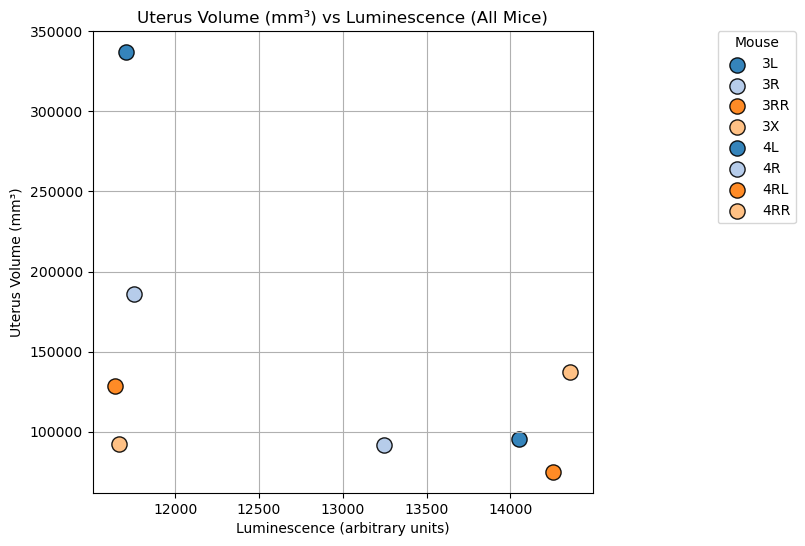

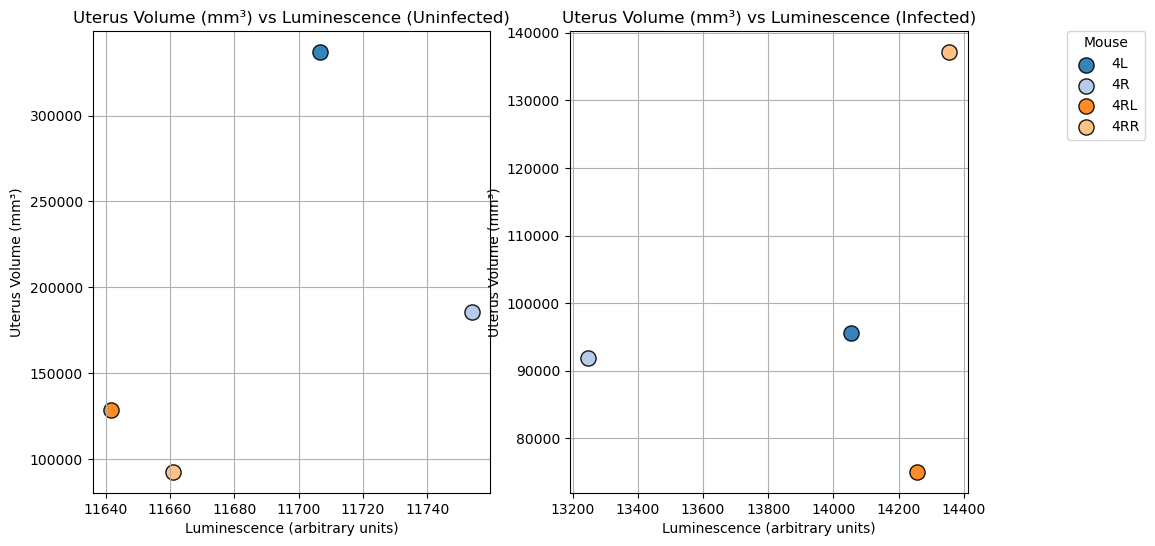

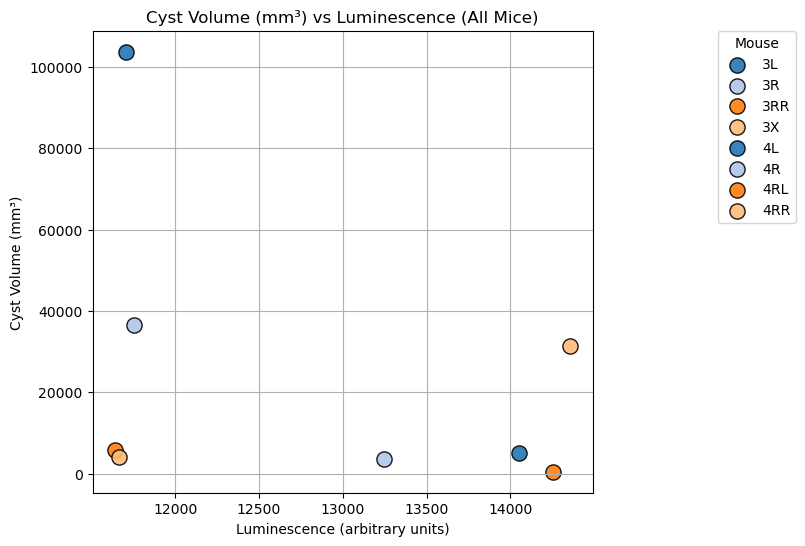

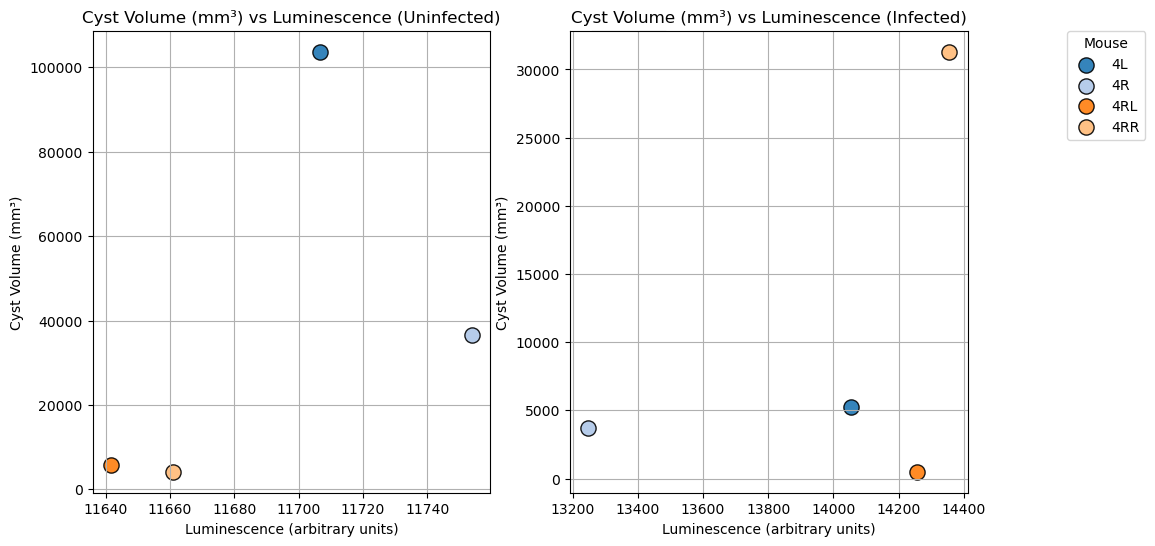

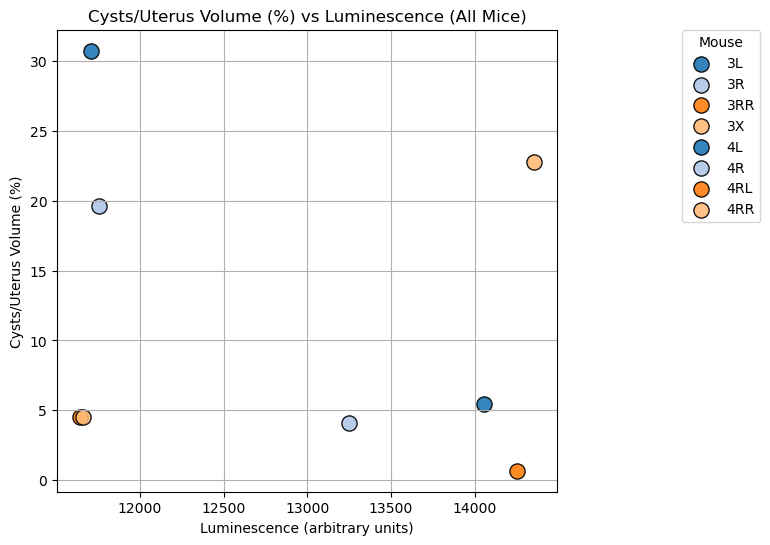

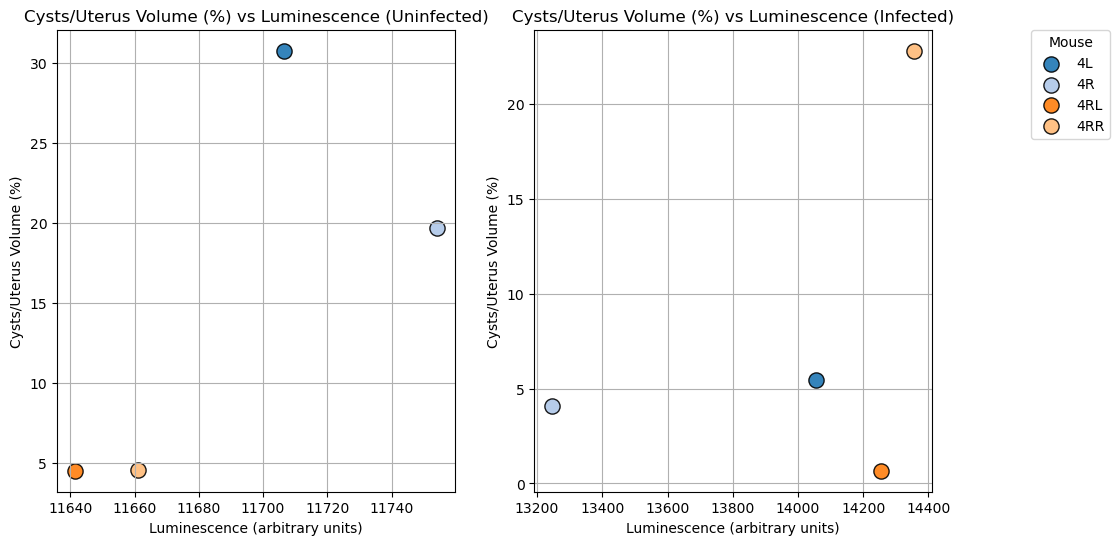

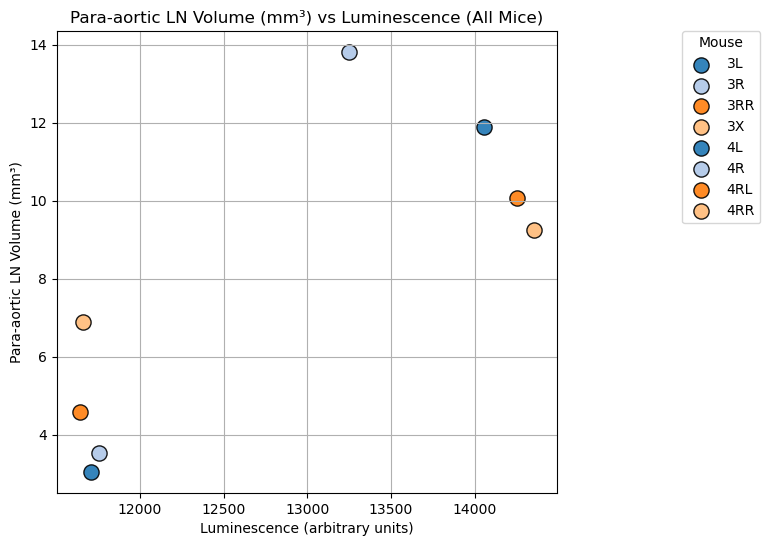

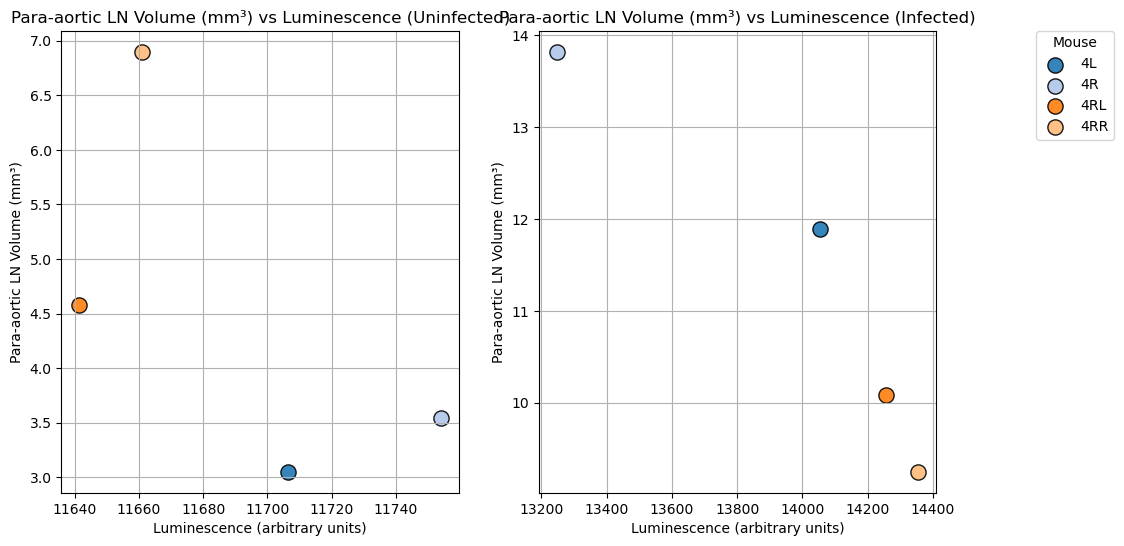

In [12]:
# --- Plotting function (Week 7 only, unique color per mouse) ---
def plot_variable(var_key, var_label, split_by_infection=False):
    fig, axs = (plt.subplots(1, 2, figsize=(14, 6)) if split_by_infection else (plt.figure(figsize=(8, 6)), [plt.gca()]))

    def plot_group(ax, infected_status):
        # assign each mouse a consistent unique color
        mice = sorted(set(e['Mouse'] for e in mri_data if e['Infected'] == infected_status))
        cmap = plt.get_cmap("tab20")   # up to 20 distinct colors
        color_map = {mouse: cmap(i % 20) for i, mouse in enumerate(mice)}

        for mouse in mice:
            entry = next(e for e in mri_data if e['Mouse'] == mouse)  # week 7 only
            lum = lum_data.get((mouse, 7), None)
            value = entry[var_key]

            if lum is not None:
                ax.scatter(lum, value, s=120, color=color_map[mouse],
                           edgecolor="k", alpha=0.9, label=mouse)

        ax.set_xlabel("Luminescence (arbitrary units)")
        ax.set_ylabel(var_label)
        ax.grid(True)

        # --- Legend outside ---
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),
                  title="Mouse", bbox_to_anchor=(1.25, 1),
                  loc="upper left", borderaxespad=0)

    if split_by_infection:
        axs[0].set_title(f"{var_label} vs Luminescence (Uninfected)")
        plot_group(axs[0], infected_status=False)

        axs[1].set_title(f"{var_label} vs Luminescence (Infected)")
        plot_group(axs[1], infected_status=True)

        plt.subplots_adjust(right=0.75)
        plt.show()
    else:
        axs[0].set_title(f"{var_label} vs Luminescence (All Mice)")
        for status in [False, True]:
            plot_group(axs[0], infected_status=status)

        plt.subplots_adjust(right=0.75)
        plt.show()


# --- Run plots ---
for var_key, var_label in variables:
    plot_variable(var_key, var_label, split_by_infection=False)
    plot_variable(var_key, var_label, split_by_infection=True)
